In [27]:
import io
import os
import pathlib
import requests
import tarfile

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import dummy, feature_extraction, metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb


In [2]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [3]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [4]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [17]:
vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.9, # ignore words that show up in more than 90% of reviews
    "min_df": 0.1, # ignore words than show up in less than 10% of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
}

features_preprocessing = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
        **vectorizer_hyperparams,
    ),
    preprocessing.FunctionTransformer(lambda csr: csr.toarray(), lambda arr: sparse.csr_matrix(arr))
)

In [18]:
train_corpus = train_df.loc[:, "text"]
X_train = features_preprocessing.fit_transform(train_corpus)

val_corpus = val_df.loc[:, "text"]
X_val = features_preprocessing.transform(val_df.loc[:, "text"])

test_corpus = test_df.loc[:, "text"]
X_test = features_preprocessing.transform(test_df.loc[:, "text"])

In [19]:
y_train = (train_df.loc[:, "sentiment"]
                   .to_numpy())
classifier = tree.DecisionTreeClassifier(max_depth=1)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

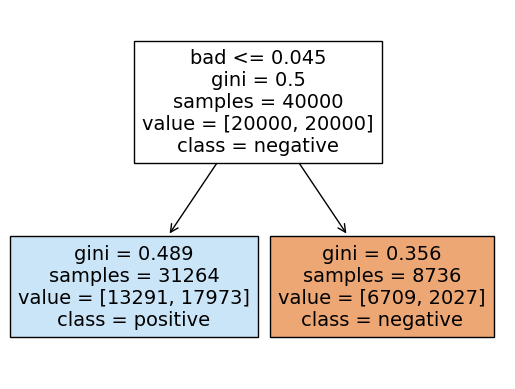

In [24]:
_vocabulary = features_preprocessing["tfidfvectorizer"].vocabulary_
_by_values = sorted(_vocabulary.items(), key=lambda item: item[1])
feature_names = [k for k, _ in _by_values]

_ = tree.plot_tree(
    classifier,
    filled=True,
    feature_names=feature_names,
    class_names=classifier.classes_
)

In [26]:
y_val = (val_df.loc[:, "sentiment"]
               .to_numpy())
classifier.score(X_val, y_val)

0.6106

In [28]:
majority_class = dummy.DummyClassifier()
majority_class.fit(X_train, y_train)

majority_class.score(X_val, y_val)

0.5

In [30]:
xgb_classifier = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xgb_classifier.fit(X_train, y_train)
xgb_classifier.score(X_val, y_val)

ValueError: ignored

In [32]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(train_df.loc[:, "sentiment"])
y_val = label_encoder.fit_transform(val_df.loc[:, "sentiment"])
y_test = label_encoder.fit_transform(test_df.loc[:, "sentiment"])


In [34]:
xgb_classifier = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xgb_classifier.fit(X_train, y_train)
xgb_classifier.score(X_val, y_val)

0.6106

In [38]:
xgb.plot_tree?

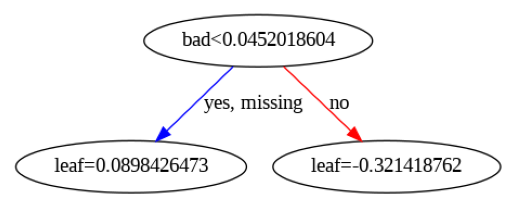

In [39]:
xgb_classifier.get_booster().feature_names = feature_names

_ = xgb.plot_tree(
    xgb_classifier,
)

In [41]:
def softmax(logits):
    return np.exp(logits) / np.sum(np.exp(logits))


In [46]:
logits = np.array([0.0898426473, -0.321418762])
softmax(logits)

array([0.6013903, 0.3986097])